# Simple Exploration of Data

In [13]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

In [4]:
data_dir = Path('../data') 
paths = {
    "current": data_dir / "patients_current.csv",
    "coming": data_dir / "patients_coming.csv",
    "historic": data_dir / "patients_historic.csv"
}

dfs = {k: pd.read_csv(v) for k, v in paths.items()}
for name, df in dfs.items():
    df.columns = [c.strip() for c in df.columns]
    dfs[name] = df

current = dfs["current"].copy()
coming = dfs["coming"].copy()
historic = dfs["historic"].copy()

schemas = {k: {"rows": len(df), "cols": list(df.columns)} for k, df in dfs.items()}
schemas

{'current': {'rows': 100,
  'cols': ['Current',
   'age',
   'sex',
   'Complexity',
   'Acuity',
   'Primary Diagnosis Summary',
   'Speciality',
   'Vitals Trend',
   'Waiting Time (days)',
   'Time since Admission (days)',
   'nextAction',
   'blocker',
   'Discharge Dependence']},
 'coming': {'rows': 100,
  'cols': ['Coming',
   'age',
   'sex',
   'Complexity',
   'Acuity',
   'Primary Diagnosis Summary',
   'Speciality',
   'Waiting Time (days)']},
 'historic': {'rows': 800,
  'cols': ['pseudo_patient_id',
   'age',
   'sex',
   'Complexity',
   'Acuity',
   'Primary Diagnosis Summary',
   'Speciality',
   'Waiting Time (days)',
   'Length of Stay (days)']}}

In [ ]:
def profile_df(df, name=None, top_n=5):
    """Return a dict containing summary views and variable profiles for a dataframe."""
    if name is None:
        name = getattr(df, "name", "<dataframe>")
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    profile = {}
    profile["name"] = name
    profile["shape"] = df.shape
    profile["dtypes"] = df.dtypes
    profile["rows"] = df.shape[0]
    profile["cols"] = list(df.columns)

    # Missingness & uniqueness
    profile["missing_count"] = df.isna().sum()
    profile["missing_pct"] = (df.isna().mean() * 100).round(2)
    profile["unique_counts"] = df.nunique()

    # Quick samples
    profile["head"] = df.head()
    profile["tail"] = df.tail()

    # Numeric summary & correlations
    profile["numeric_describe"] = df[numeric_cols].describe().T if numeric_cols else pd.DataFrame()
    profile["correlation"] = df[numeric_cols].corr() if len(numeric_cols) > 1 else pd.DataFrame()

    # Categorical summaries (top values)
    top_values = {}
    for c in cat_cols:
        top_values[c] = df[c].value_counts(dropna=False).head(top_n)
    profile["categorical_top"] = top_values

    # Basic distributions for numeric columns: mean, std, median, IQR
    numeric_stats = {}
    for c in numeric_cols:
        s = df[c].dropna()
        numeric_stats[c] = {
            "mean": s.mean(),
            "std": s.std(),
            "median": s.median(),
            "q1": s.quantile(0.25),
            "q3": s.quantile(0.75),
            "iqr": s.quantile(0.75) - s.quantile(0.25),
            "min": s.min(),
            "max": s.max(),
        }
    profile["numeric_stats"] = pd.DataFrame(numeric_stats).T if numeric_stats else pd.DataFrame()

    return profile

# Generate profiles for each dataframe in `dfs` (current, coming, historic)
profiles = {}
for key, df_ in dfs.items():
    profiles[key] = profile_df(df_, name=key)

# Create a compact summary view DataFrame for quick comparison
summary_rows = []
for k, p in profiles.items():
    summary_rows.append({
        "name": k,
        "rows": p["rows"],
        "cols": len(p["cols"]),
        "num_numeric": len(dfs[k].select_dtypes(include=[np.number]).columns),
        "num_categorical": len(dfs[k].select_dtypes(include=['object','category','bool']).columns),
        "total_missing": int(p["missing_count"].sum()),
        "pct_missing": float(p["missing_pct"].mean()),  # average pct missing across cols
    })
summary_view = pd.DataFrame(summary_rows).set_index("name")

# Display concise summaries for notebook consumption
print("Summary view (one-line per dataframe):")
print(summary_view)
print("\nProfiles have been created and stored in the `profiles` dict.")

# Keep variables available for further interactive exploration
summary = summary_view

Summary view (one-line per dataframe):
          rows  cols  num_numeric  num_categorical  total_missing  pct_missing
name                                                                          
current    100    13            5                8              0          0.0
coming     100     8            4                4              0          0.0
historic   800     9            5                4              0          0.0

Profiles have been created and stored in the `profiles` dict.


In [6]:
profiles['current']['numeric_describe']

,count,mean,std,min,25%,50%,75%,max
age,100.0,51.7500,24.991463,2.0,33.75,52.500,73.0000,99.00
Complexity,100.0,1.0376,0.291538,0.5,0.79,1.105,1.3225,1.49
Acuity,100.0,2.9000,1.466804,1.0,1.00,3.000,4.0000,5.00
Waiting Time (days),100.0,50.8100,76.780376,1.0,6.75,20.000,63.2500,490.00
Time since Admission (days),100.0,2.4500,8.023167,0.0,0.00,1.000,2.0000,77.00


In [15]:
profiles['current']['correlation']

,age,Complexity,Acuity,Waiting Time (days),Time since Admission (days)
age,1.000000,-0.200108,0.041195,0.015904,-0.014848
Complexity,-0.200108,1.000000,-0.066233,0.080681,-0.055543
Acuity,0.041195,-0.066233,1.000000,0.021086,-0.032187
Waiting Time (days),0.015904,0.080681,0.021086,1.000000,0.084668
Time since Admission (days),-0.014848,-0.055543,-0.032187,0.084668,1.000000


In [18]:
profiles['current']['categorical_top']['Speciality']

Speciality
General Internal Medicine    58
Gastronenterology            22
Geriatric Medicine            6
Trauma and Orthopaedics       6
Ophthalmology                 4
Name: count, dtype: int64

In [22]:
profiles['current']['unique_counts']

Current                        100
age                             62
sex                              2
Complexity                      64
Acuity                           5
Primary Diagnosis Summary       53
Speciality                       6
Vitals Trend                     3
Waiting Time (days)             59
Time since Admission (days)     11
nextAction                       5
blocker                          7
Discharge Dependence             2
dtype: int64

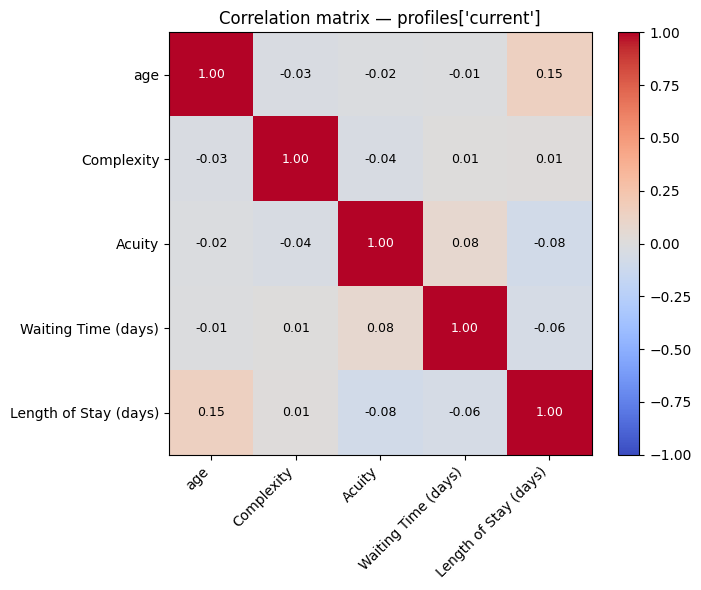

In [26]:
corr = profiles['historic']['correlation']

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)

cols = corr.columns.tolist()
ax.set_xticks(range(len(cols)))
ax.set_yticks(range(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha="right")
ax.set_yticklabels(cols)

# Annotate cells with correlation values
for i in range(len(cols)):
    for j in range(len(cols)):
        val = corr.iat[i, j]
        color = "white" if abs(val) > 0.5 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=color, fontsize=9)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Correlation matrix — profiles['current']")
plt.tight_layout()
plt.show()